In [41]:
import numpy as np
import matplotlib.pyplot as plt
from gpaw import restart
from ase import *
from ase.io import read
from gpaw import *

from ase.units import Hartree
from gpaw.utilities.dos import LCAODOS, RestartLCAODOS, fold
from gpaw.lcao.tools import get_lcao_hamiltonian

from pathlib import Path

from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling, lowdin_rotation
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy


### Helper functions

In [13]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(5, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


In [22]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)


## Visualize structure and how the atoms are ordered

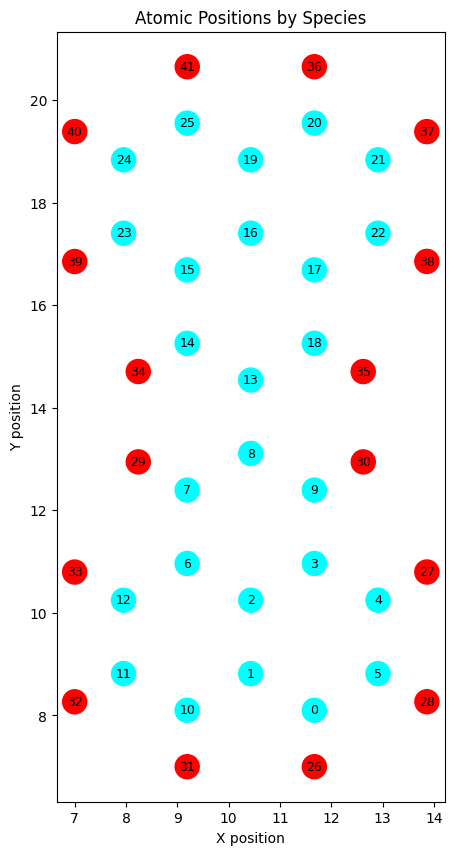

In [14]:
atoms = read('./struct.xyz')
element_colors = {'C':'cyan','H':'red'}

plot_atomic_positions_by_species(atoms, element_colors)

### Check DFT calculations

In [15]:
gpaw_file = './struct.gpw'
calc = GPAW(gpaw_file, txt=None)
dos = RestartLCAODOS(calc)
pdos = LCAODOS(calc)


### Get Hamiltonian and Overlap matrices in the LCAO basis

In [16]:
# Since this is a molecule, I've performed a Gamma point calculation and the assumption is the H_gamma is equivalent to a real space Hamiltonian H_R.

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= E_fermi * S_lcao

Condition number: 5.4e+04


### Get Hamiltonian and Overlap matrices in the LO basis

In [45]:
# Perform subdiagonalization

nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species (C 2 pz in this case)
active = {'C': [3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

for idx in index_active_region:
    if Usub[idx-1,idx] < 0.: # change sign
        Usub[:,idx] *= -1
        
# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)

lowdin = True
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)

    H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
    S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

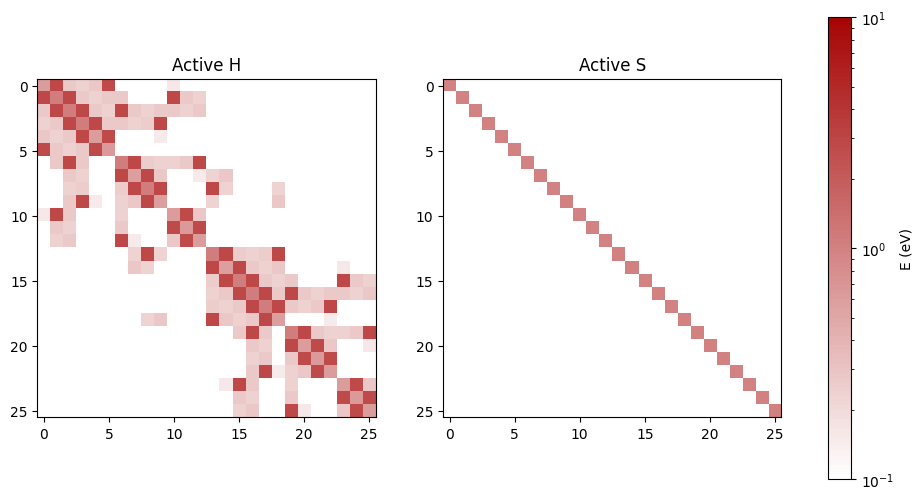

In [46]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_active), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Active H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_active), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Active S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


Based on the ordering of the indices in the visualization of the structure (top of the notebook), and the naming convention in the figure below,

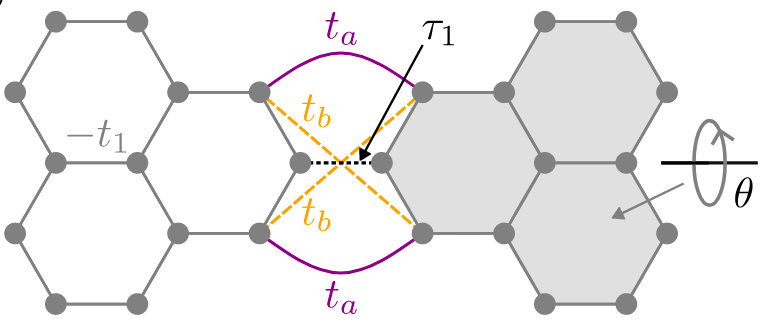

1. t_1 = hopping between atom #1 and #2
2. tau_1 = hopping between atom #8 and #13
3. t_a = hopping between atom #7 and #14
4. t_b = hopping between atom #7 and #18

In [47]:
print("t1 = ",H_active[1,2])
print("tau_1 = ",H_active[8,13])
print("t_a = ",H_active[7,14])
print("t_b = ",H_active[7,18])

# Onsite C pz-pz terms
print("onsite = ",np.diag(H_active))

t1 =  -2.842862258332445
tau_1 =  -2.845015725118648
t_a =  -0.2826315355968504
t_b =  0.05083766763930989
onsite =  [0.61098436 1.08141793 1.05743511 1.08035965 0.61079034 0.64039125
 1.07885018 0.59015293 1.09410579 0.58946821 0.61282481 0.64165431
 0.60994354 1.09454725 0.58952474 1.08100086 1.0574999  1.07913426
 0.58902741 1.08474919 0.61251255 0.64150236 0.61136527 0.61067826
 0.64012319 0.61438416]


In [48]:
np.diag(S_active)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [49]:
# Mask the diagonal by creating a boolean mask
non_diag_mask = ~np.eye(26, dtype=bool)

# Extract non-diagonal elements
non_diag_elements = S_active[non_diag_mask]

# Find the largest non-diagonal value
max_non_diag_value = np.max(non_diag_elements)

max_non_diag_value

1.4988010832439613e-15